# In this tutorial, we'll go through an analysis of publicly available 1000 genomes data

**Thank you Tim Majarian for providing the notebook for this demonstration**

## We're using the phase 3 genotypes with some mock phenotype measures for Type 2 Diabetes

### First, we'll load some packages
#### FISS -  tools for interacting with a Firecloud workspace
#### Pandas & Numpy - for printing and manipulating some of the data
#### Pprint - for pretty printing

In [1]:
%%capture
from firecloud import fiss
import pandas as pd
pd.set_option('display.max_row', 10000)
import os
import numpy as np
from pprint import pprint


### Next, let's take a look at the workspace data model to see how many samples and participants we have.
#### Check out the data model to see how we have populated it.
#### In this case, a *participant* is a set of genotypes and a *sample* is a set of phenotypes and associated data for a single analysis.
#### Each *sample* refers to a *participant*, both in the data model and in the actual phenotypes.

In [2]:
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']

In [3]:
BILLING_PROJECT_ID

'workshop-temp'

In [4]:
#This value needs to be changed to the current workspace
WORKSPACE = "BroadE-Day4-BigQuery"
WORKSPACE

'BroadE-Day4-BigQuery'

In [5]:
# Take a look at the metadata that we have in the data model of our workspace.
ent_types = fiss.fapi.list_entity_types(BILLING_PROJECT_ID , WORKSPACE).json()
for t in ent_types.keys():
    print (t, "count:", ent_types[t]['count'])

participant count: 2
sample count: 2


In [53]:
# The genotype filepaths are stored in the participant entity
# Here we get all of the participant metadata in json format using FISS
participant = fiss.fapi.get_entities(BILLING_PROJECT_ID, WORKSPACE, "participant").json()[0]

In [54]:
participant

{'attributes': {'vcf': 'gs://terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/1kg_genotypes/1kg.vcf.bgz'},
 'entityType': 'participant',
 'name': '1kg'}

In [8]:
# The filepaths are in the column 'vcf_gz' in the datamodel. Put these filepaths into a python list
vcf_files = participant['attributes']['vcf']
pprint(vcf_files)

'gs://terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/1kg_genotypes/1kg.vcf.bgz'


In [9]:
# We'll also want the phenotype file for a GWAS. This is in the sample metadata.
sample = fiss.fapi.get_entities(BILLING_PROJECT_ID, WORKSPACE, "sample").json()[0]
pprint(sample)

{'attributes': {'kinship': 'gs://terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/1kg_kinship/1kg_GRCh38_genotypes_20170504_kinship.txt',
                'participant': '1kg',
                'phenotypes': 'gs://terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/1kg_phenotypes/1kg_demo_phenotypes.csv',
                'sample_ids': 'gs://terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/1kg_sampleids/1kg_demo_phenotypes.sample.ids.txt'},
 'entityType': 'sample',
 'name': '1kg_demo'}


In [10]:
# Find the phenotype filepath under the column 'phenotypes'
phenotypes = sample['attributes']['phenotypes']
pprint(phenotypes)

'gs://terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/1kg_phenotypes/1kg_demo_phenotypes.csv'


In [11]:
# get the right bucket to write out to
bucket = 'gs://'+fiss.fapi.get_workspace(BILLING_PROJECT_ID, WORKSPACE).json()['workspace']['bucketName']+'/demo-output/'

In [12]:
bucket

'gs://fc-4f9b3ba9-f977-417d-b087-12230bfb81bc/demo-output/'

One of the quirks of gsutil is that in order to create a directory, a file needs to placed into the directory.  That is okay, because we are going to take a snapshot of our python setup and put it in the demo-output directory in case we need to refer to this notebook in the future and reproduce the versions of the python tools installed on this date.

In [51]:
import datetime
!if [ -e provenance.*.txt ];then rm provenance.*.txt; fi
dateTimeStamp = datetime.datetime.now().date() #in the format YYYYMMDDHHMMSS
print(str(datetime.datetime.now()),file=open("provenance.txt", "a"))
!pip freeze >> provenance.txt
os.rename("provenance.txt",str(dateTimeStamp) + ".provenance.txt")
!gsutil mv *.provenance.txt $bucket

Copying file://2019-03-28.provenance.txt [Content-Type=text/plain]...
Removing file://2019-03-28.provenance.txt...                                    

Operation completed over 1 objects/591.0 B.                                      


### Now that we know where to find our data, let's start Hail and do some manipulation.

In [14]:
# start hail context
import hail as hl
hl.init(sc = sc, default_reference = "GRCh37", log = bucket + 'demo.log')

Running on Apache Spark version 2.2.3
SparkUI available at http://10.128.0.27:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.10-bb21797a1f06
LOGGING: writing to gs://fc-4f9b3ba9-f977-417d-b087-12230bfb81bc/demo-output/demo.log


In [15]:
import bokeh.io
from bokeh.resources import INLINE
from bokeh.io import *
bokeh.io.output_notebook(INLINE) 

Loading BokehJS ...

In [16]:
# load the genotype data
geno = (
    hl
    .import_vcf(
        vcf_files
    )
)

In [17]:
geno.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    }
----------------------------------------
Entry fields:
    'GT': call
    'AD': array<int32>
    'DP': int32
    'GQ': int32
    'PL': array<int32>
----------------------------------------
Colu

In [18]:
# Write it back out into Hail's matrix table format so downstream is faster
geno.write('./1kg.mt', overwrite=True)

2019-03-28 19:08:21 Hail: INFO: Coerced sorted dataset
2019-03-28 19:08:27 Hail: INFO: wrote matrix table with 10961 rows and 284 columns in 2 partitions to ./1kg.mt


In [19]:
# Read genotype data back in
geno = hl.read_matrix_table('./1kg.mt')

In [20]:
# Count the number of variants/samples that we have
geno.count()

(10961, 284)

In [21]:
# read the phenotype data
pheno = (
    hl
    .import_table(
        phenotypes, 
        delimiter = ",",
        types={
            'last_exam_age': hl.tfloat64, 
            't2d': hl.tint32, 
            'bmi': hl.tfloat64,
            'FG': hl.tfloat64
        }
    )
)

pheno = pheno.key_by('sample_id')

2019-03-28 19:08:28 Hail: INFO: Reading table with no type imputation
  Loading column 'sample_id' as type 'str' (type not specified)
  Loading column 'population' as type 'str' (type not specified)
  Loading column 'ancestry' as type 'str' (type not specified)
  Loading column 'sex' as type 'str' (type not specified)
  Loading column 'last_exam_age' as type 'float64' (user-specified)
  Loading column 't2d' as type 'int32' (user-specified)
  Loading column 'bmi' as type 'float64' (user-specified)
  Loading column 'FG' as type 'float64' (user-specified)



In [22]:
# show phenotype data
pheno_pd = pheno.to_pandas()
pheno_pd.head(n = 20)

,sample_id,population,ancestry,sex,last_exam_age,t2d,bmi,FG
0,HG00096,GBR,EUR,M,44.395244,0,30.735215,4.221257
1,HG00097,GBR,EUR,F,47.698225,0,34.059806,7.432350
2,HG00099,GBR,EUR,F,65.587083,0,39.904038,5.676863
3,HG00100,GBR,EUR,F,50.705084,1,31.211378,6.323938
4,HG00101,GBR,EUR,M,51.292877,0,30.246678,5.378753
5,HG00102,GBR,EUR,F,67.150650,1,39.701478,6.622569
6,HG00103,GBR,EUR,M,54.609162,1,29.579717,4.332983
7,HG00105,GBR,EUR,M,37.349388,1,33.246828,4.646803
8,HG00106,GBR,EUR,F,43.131471,0,26.358046,7.230910
9,HG00107,GBR,EUR,M,45.543380,0,30.652322,1.670776


In [23]:
# simplify some columns by reannotating the phenotype data
pheno = (
    pheno
    .annotate(is_female = hl.cond(pheno['sex'] == 'F', True, False), 
              has_t2d = hl.cond(pheno['t2d'] == 1, True, False)
    )
)


In [24]:
# show phenotype data again to show changes
pheno_pd = pheno.to_pandas()
pheno_pd.head(n = 20)

2019-03-28 19:08:33 Hail: INFO: Coerced sorted dataset


,sample_id,population,ancestry,sex,last_exam_age,t2d,bmi,FG,is_female,has_t2d
0,HG00096,GBR,EUR,M,44.395244,0,30.735215,4.221257,False,False
1,HG00097,GBR,EUR,F,47.698225,0,34.059806,7.432350,True,False
2,HG00099,GBR,EUR,F,65.587083,0,39.904038,5.676863,True,False
3,HG00100,GBR,EUR,F,50.705084,1,31.211378,6.323938,True,True
4,HG00101,GBR,EUR,M,51.292877,0,30.246678,5.378753,False,False
5,HG00102,GBR,EUR,F,67.150650,1,39.701478,6.622569,True,True
6,HG00103,GBR,EUR,M,54.609162,1,29.579717,4.332983,False,True
7,HG00105,GBR,EUR,M,37.349388,1,33.246828,4.646803,False,True
8,HG00106,GBR,EUR,F,43.131471,0,26.358046,7.230910,True,False
9,HG00107,GBR,EUR,M,45.543380,0,30.652322,1.670776,False,False


In [25]:
# see how many inidividuals belong to each population group
pprint(pheno.aggregate(hl.agg.counter(pheno.population)))

2019-03-28 19:08:35 Hail: INFO: Coerced sorted dataset


{'ACB': 96,
 'ASW': 61,
 'CEU': 99,
 'CHB': 103,
 'CLM': 94,
 'GBR': 91,
 'GIH': 103,
 'JPT': 104,
 'LWK': 99,
 'MXL': 64,
 'PUR': 104,
 'YRI': 108}


In [26]:
#Show the number of individuals in the mock data assigned as Type2 Diabetes patients
pheno.aggregate(hl.agg.count_where(pheno.t2d == 1))

2019-03-28 19:08:36 Hail: INFO: Coerced sorted dataset


228

In [27]:
#Show the number of individuals in the mock data assigned as Controls
pheno.aggregate(hl.agg.count_where(pheno.t2d == 0))

2019-03-28 19:08:37 Hail: INFO: Coerced sorted dataset


898

In [28]:
#Examine the differences in mean Body Mass Index (bmi) 
#Between individuals in the mock data set assigned to Type 2 Diabetes(t2d == 1) and not assigned (t2d == 0)
result_t2d_bmi = pheno.group_by(pheno.t2d).aggregate(mean_bmi=hl.int32(hl.agg.mean(pheno.bmi)))
result_t2d_bmi.show()

2019-03-28 19:08:38 Hail: INFO: Coerced sorted dataset
2019-03-28 19:08:39 Hail: INFO: Coerced sorted dataset


+-------+----------+
|   t2d | mean_bmi |
+-------+----------+
| int32 |    int32 |
+-------+----------+
|     0 |       17 |
|     1 |       22 |
+-------+----------+



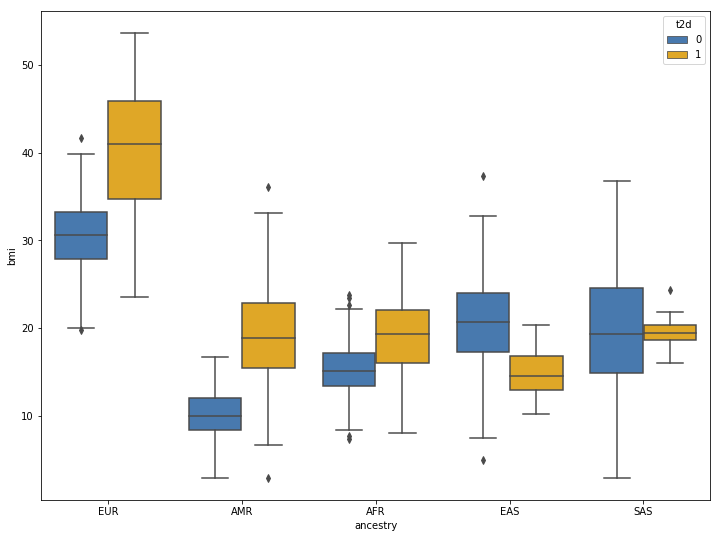

In [29]:
# Lets look at the distribution of BMI per ancestry devided by case vs control
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
ax = sns.boxplot(x="ancestry", y="bmi", hue="t2d", data=pheno_pd, palette=sns.xkcd_palette(["windows blue", "amber"]))

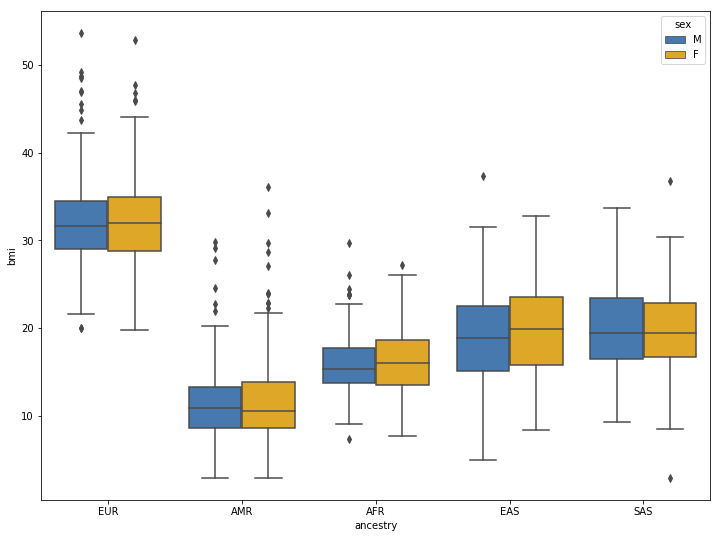

In [30]:
# distributiuon of bmi over sex
plt.rcParams["figure.figsize"] = [12,9]
ax = sns.boxplot(x="ancestry", y="bmi", hue="sex", data=pheno_pd, palette=sns.xkcd_palette(["windows blue", "amber"]))

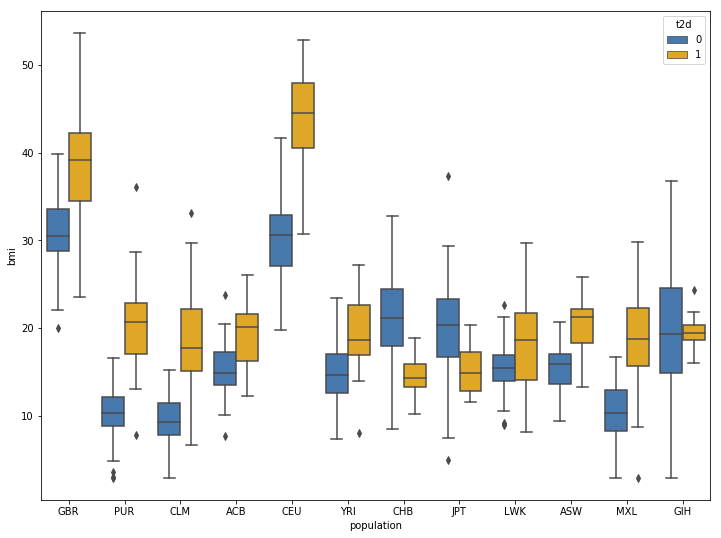

In [31]:
# "distribution of bmi per population"
plt.rcParams["figure.figsize"] = [12,9]
ax = sns.boxplot(x="population", y="bmi", hue="t2d", data=pheno_pd, palette=sns.xkcd_palette(["windows blue", "amber"]))


In [32]:
# Annotated genotype data with phenotype information
geno = (
    geno.annotate_cols(pheno = pheno[geno.s])
)


In [33]:
# Filter to those samples in the phenotype file with t2d information
geno = (
    geno
    .filter_cols(hl.is_defined(geno.pheno['t2d']), keep=True)
)

### We can also look at the genotype data by generating some built-in QC measures.

In [34]:
# sample QC
geno = hl.sample_qc(geno)

In [35]:
# variant QC
geno = hl.variant_qc(geno)

2019-03-28 19:08:44 Hail: INFO: Coerced sorted dataset


In [36]:
# Filter to common variants
geno = (
    geno
    .filter_rows(
       geno.variant_qc.AF[1] > 0.01
    )
)


In [37]:
# take a look at the sample annotation schema
geno.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'pheno': struct {
        population: str, 
        ancestry: str, 
        sex: str, 
        last_exam_age: float64, 
        t2d: int32, 
        bmi: float64, 
        FG: float64, 
        is_female: bool, 
        has_t2d: bool
    }
    'sample_qc': struct {
        dp_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        gq_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
  

In [38]:
# See the distribution of nonRef alleles
p = hl.plot.histogram(geno.sample_qc.n_non_ref, legend='# Alt alleles')
show(p)

2019-03-28 19:08:47 Hail: INFO: Coerced sorted dataset
2019-03-28 19:08:49 Hail: INFO: Coerced sorted dataset


### We can use PCA to visualize sample relatedness

In [39]:
# LD prune
pruned_variant_table = hl.ld_prune(geno.GT, r2=0.2, bp_window_size=500000)
geno = geno.filter_rows(hl.is_defined(pruned_variant_table[geno.row_key]))

2019-03-28 19:08:51 Hail: INFO: ld_prune: running local pruning stage with max queue size of 838861 variants
2019-03-28 19:08:55 Hail: INFO: wrote table with 8644 rows in 2 partitions to hdfs://saturn-d9e28083-ff23-4edf-8435-a1809c249ffb-m/tmp/hail.Rd5Fen68pRto/d7WGYNvXV2
2019-03-28 19:08:59 Hail: INFO: Wrote all 3 blocks of 8644 x 117 matrix with block size 4096.
2019-03-28 19:09:26 Hail: INFO: wrote table with 0 rows in 5 partitions to hdfs://saturn-d9e28083-ff23-4edf-8435-a1809c249ffb-m/tmp/hail.Rd5Fen68pRto/uF7o9ydbA6


In [40]:
# Run PCA
eigenvalues, pcs, _ = hl.hwe_normalized_pca(geno.GT)

2019-03-28 19:09:29 Hail: INFO: hwe_normalized_pca: running PCA using 8720 variants.
2019-03-28 19:09:31 Hail: INFO: pca: running PCA with 10 components...


In [41]:
# Add PCA values to our dataset
geno = geno.annotate_cols(scores = pcs[geno.s].scores)

In [42]:
# visualize
p = hl.plot.scatter(geno.scores[0],
                    geno.scores[1],
                    label=geno.pheno.ancestry,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)


2019-03-28 19:09:40 Hail: INFO: Coerced sorted dataset


### Let's run a simple regression analysis using the first 3 PCA's and some other phenotypic information as covariates.

In [43]:
gwas = hl.linear_regression_rows(
    y=geno.pheno.has_t2d,
    x=geno.GT.n_alt_alleles(),
    covariates=[1.0, geno.pheno.is_female, geno.scores[0], geno.scores[1], geno.scores[2]])

2019-03-28 19:09:41 Hail: INFO: Coerced sorted dataset
2019-03-28 19:09:42 Hail: INFO: linear_regression_rows: running on 117 samples for 1 response variable y,
    with input variable x, and 5 additional covariates...


In [44]:
# QQ plot
p = hl.plot.qq(gwas.p_value)
show(p)

2019-03-28 19:09:44 Hail: INFO: Ordering unsorted dataset with network shuffle


In [45]:
# MH plot
p = hl.plot.manhattan(gwas.p_value)
p.ray(x=[0], y=[4], length=0, angle=0, line_width=2, line_color ="red", line_dash ="dashed")
show(p)

### Finally, we'll save the results and push them back to the data model so they can be accessed through the Firecloud UI.

In [46]:
# export the association results as a tsv
result_file = bucket+str(dateTimeStamp)+'-Hail-Demo-Mock-Data.association.results.tsv'


In [47]:
# export summary stats from gwas
var_table = (
    gwas
    .key_by()
    .select('locus','alleles','beta','standard_error','t_stat','p_value')
)

var_table.export(result_file)

2019-03-28 19:09:48 Hail: INFO: while writing:
    gs://fc-4f9b3ba9-f977-417d-b087-12230bfb81bc/demo-output/2019-03-28-Hail-Demo-Mock-Data.association.results.tsv
  merge time: 727.768ms


In [48]:
# save the notebook and an HTML rendering
%notebook Hail-Demo-Mock-Data.ipynb
! jupyter nbconvert --to html Hail-Demo-Mock-Data.ipynb

[NbConvertApp] Converting notebook Hail-Demo-Mock-Data.ipynb to html
[NbConvertApp] Writing 317396 bytes to Hail-Demo-Mock-Data.html


In [49]:
# move the results, notebook, and html over to the workspace bucket
notebook_file = bucket+str(dateTimeStamp)+'-Hail-Demo-Mock-Data.ipynb'
html_file = bucket+str(dateTimeStamp)+'-Hail-Demo-Mock-Data.html'
! gsutil cp Hail-Demo-Mock-Data.ipynb {notebook_file}
! gsutil cp Hail-Demo-Mock-Data.html {html_file}
! rm Hail-Demo-Mock-Data.ipynb
! rm Hail-Demo-Mock-Data.html


Copying file://Hail-Demo-Mock-Data.ipynb [Content-Type=application/octet-stream]...
/ [1 files][ 12.9 KiB/ 12.9 KiB]                                                
Operation completed over 1 objects/12.9 KiB.                                     
Copying file://Hail-Demo-Mock-Data.html [Content-Type=text/html]...
/ [1 files][310.0 KiB/310.0 KiB]                                                
Operation completed over 1 objects/310.0 KiB.                                    


In [50]:
# update the data model to include the results
cols = ['entity:sample_id',
    'participant',
    'phenotypes',
    'notebook',
    'html',
    'results']


vals = [str(dateTimeStamp)+'-Hail-Demo-Mock-Data',
            '1kg_GRCh38_genotypes_20170504',
            'terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/1kg_phenotypes/1kg_GRCh38_genotypes_20170504_demo_phenotypes.csv',
            notebook_file,
            html_file,
            result_file
       ]

entity = '\n'.join(['\t'.join(cols),'\t'.join(vals)])
fiss.fapi.upload_entities(BILLING_PROJECT_ID,WORKSPACE,entity)

<Response [200]>